In [1]:
from typing import Union

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth

from scipy.stats import mannwhitneyu as mnu
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
from scipy.stats import ttest_1samp
from scipy.stats import permutation_test
from scipy.stats import norm

from sklearn.metrics.pairwise import cosine_similarity as cosine
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from scipy.stats import kendalltau as kendall

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

## Definitions ##

In [2]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def mk_repmat_kernel(input_ls, plot_kernel=False):
    '''
    Args:
        input_ls:    list with the number of samples per condition, i.e., 
                     the list size is the number of categories
        plot_kernel: if True, the created kernel will be plotted
    Returns:
        kernel: (N,N) theoretical ground-truth representatational matrix,
                where N is the total number of samples
    '''

    kernel = np.zeros([sum(input_ls),sum(input_ls)])
    counter_ind = 0
    for i in input_ls:
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        kernel[np.ix_(inds,inds)] = 1
        
    if plot_kernel:
        plt.figure(figsize=(2,2))
        plt.imshow(kernel, cmap='coolwarm')
        plt.axis('off')

    return kernel


def mk_repmat_data(input_data, sim_method='cosine', print_info=False):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
        print_info: if True, the progression will be printed
    Returns:
        repmat: (N,N) representatational matrix, where N is the total number of samples
    '''

    if sim_method=='cosine':
        repmat = cosine(input_data.T)
    elif sim_method=='spearman':
        CorRows = []
        for stim_i in range(input_data.shape[1]):
            CorCols = []
            for stim_j in range(input_data.shape[1]):
                CorCols.append(spearman(input_data[:,stim_i], input_data[:,stim_j])[0])

                if print_info:
                    print('stim_i: ' + str(((stim_i+1)/input_data.shape[1])*100) +
                          ' | ' + 'stim_j: ' + str(((stim_j+1)/input_data.shape[1])*100))

            CorRows.append(CorCols)
        repmat = np.array(CorRows)
    
    return repmat

def mk_total_repmat_data(input_data, sim_method='cosine'):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
    Returns:
        total_repmat: (N,N,T) representatational matrix, where N is the total number of samples and
                      T is the number of time-points
    '''

    total_repmat = []
    for iTime in range(input_data.shape[2]):
        tmp_retmat = mk_repmat_data(input_data=input_data[:,:,iTime], sim_method=sim_method, print_info=False)
        total_repmat.append(tmp_retmat)
    return np.transpose(np.array(total_repmat), (1,2,0))


def plot_repmat(input_repmat, plot_sz=3, show_clb=False, titles=[], colormap='coolwarm', cbar_label='Cosine Similarity (au)', fig_title=''):
    '''
    Args:
        input_repmat: (M,N,N) representatational matrices, where M is the number of conditions and
                      N is the total number of samples
        plot_sz:      size of the generated plot
        show_clb:     if True, colorbar will be shown
        titles:       list of titles of each representatational matrix
        colormap:     colormap for the generated plot
        cbar_label:   colorbar label
    Returns:
        none
    '''

    if not titles: titles=['']*len(input_repmat)
    if show_clb==True:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat)+1, figsize=(3*plot_sz,plot_sz),  dpi=500)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat), figsize=(3*plot_sz,plot_sz),  dpi=500)

    for ax,repmat,tle in zip(axs.flatten(), input_repmat, titles):
        ax.imshow(repmat, cmap=colormap)
        ax.set_title(tle, fontsize=5)
        ax.axis('off')
    if show_clb:
        clb = mbar.ColorbarBase(ax=axs[-1], cmap=colormap, orientation="vertical", ticks=[0,1])
        clb.set_label(cbar_label, fontsize=plot_sz*3)
        clb.outline.set_visible(False)
    plt.suptitle(fig_title, fontsize=plot_sz*10)


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def compute_similarity(data_mat, kernel_mat, sim_method='kendall'):
    '''
    Args:
        data_mat:   (N,N) representatational matrix created from data,
                    where N is the number of conditions
        kernel_mat: (N,N) theoretical ground-truth representatational matrix,
                    where N is the number of conditions
        sim_method: method to calculate similarity
    Returns:
        similarity: similarity value between data_mat and kernel_mat
    '''
    if sim_method!='kendall':
        data_mat = data_mat.reshape((data_mat.shape[0]**2,1))
        kernel_mat = kernel_mat.reshape((kernel_mat.shape[0]**2,1))

    if sim_method=='kendall':
        similarity = kendall(data_mat, kernel_mat)[0]
    elif sim_method=='spearman':
        similarity = spearman(data_mat, kernel_mat)[0]
    elif sim_method=='pearson':
        similarity = pearson(data_mat, kernel_mat)[0]

    return similarity


def compute_rsa(data_input, conds_ls=[], sp_kernel=[], sim_method='kendall', print_info=False):
    '''
    Args:
        data_input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        conds_ls:   list with the number of samples per condition, i.e., the list size is the number
                    of categories, and each item is the number of stimuli per that category
        sp_kernel:  (N,N) representatational matrix, i.e., specific kernel,
                    where N is the number of stimuli
        sim_method: method to calculate similarity
        print_info: if True, the progression will be printed
    Returns:
        rsa: (N,) vector of similarity values, where N is the number of timepoints
    '''
    
    if not sp_kernel: kernel = mk_repmat_kernel(conds_ls)
    elif not conds_ls: kernel = sp_kernel

    rsa = []
    for i_time in range(data_input.shape[2]):
        temp_mat = []
        temp_mat = mk_repmat_data(data_input[:,:,i_time])
        rsa.append(compute_similarity(temp_mat, kernel, sim_method))

        if print_info:
            print('% ' + str(((i_time+1)/data_input.shape[2])*100))
            
    return np.array(rsa)


def repmat_extremizer(input_repmat, szs_ls, coeffs=[1,1], clip_vals=[0,1]):
    '''
    Args:
        input_repmat: (N,N) representatational matrix, where N is the total number of stimuli
        szs_ls:       (N,) list with the number of samples per condition, i.e., 
                      the list size is the number of categories
        coeffs:       (2,) list of coefficients to scale the "input_repmat"; members of the same category
                      will be scaled by coeffs[0], and members of different categories will be scaled by
                      coeffs[1]
        clip_vals:    (2,) list of minimum (clip_vals[0]) and maximum (clip_vals[1]) acceptable values for
                      representatational matrix
    Returns:
        trans_repmat: (N,N) transformed representatational matrix, where N is the total number of stimuli
    '''

    coeffs = np.sort(coeffs)
    clip_vals = np.sort(clip_vals)
    coeff_mat = np.array(coeffs[0]) * np.ones([input_repmat.shape[0],input_repmat.shape[1]])
    counter_ind = 0
    for i in tqdm(szs_ls):
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        coeff_mat[np.ix_(inds,inds)] = coeffs[1]
    trans_repmat = input_repmat * coeff_mat
    trans_repmat[trans_repmat<clip_vals[0]] = clip_vals[0]
    trans_repmat[trans_repmat>clip_vals[1]] = clip_vals[1]

    return trans_repmat


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def rsaGranger(src: np.array, dst: np.array, n: int, k: int, mdl=Ridge, print_info=False, timepoints=[]) -> Union[np.array, dict]:
    '''
    Args:
        src:        (N,N,T) array of representatational matrices over time for the sender area, where T is time and 
                    each (N,N) is a representatational matrix at a time-point, in which N is the total number of stimuli
        dst:        same as "src", for the reciever area. "src" and "dst" must have the same shape
        n:          ---
        k:          ---
        mdl:        ---
        print_info: if True, the progression will be printed
        timepoints: (N,) np.array vector of timepoints
    Returns:
        (N,) value of granger predictivity for "src-to-dst" direction
        (N,) vector of new timepoints
    '''

    assert((src.shape == dst.shape))
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,src.shape[2])

    triu = np.triu_indices(src.shape[0], k=1)
    time_stamps, unex_r, unex_f, norm_w = [], [], [], []

    for iTime in range(n+k, src.shape[2]):
        
        y = dst[triu[0], triu[1], iTime]
        x_r = dst[triu[0], triu[1], (iTime-n-k):(iTime-k+1)]
        x_f = np.concatenate((
            dst[triu[0], triu[1], (iTime-n-k):(iTime-k+1)], 
            src[triu[0], triu[1], (iTime-n-k):(iTime-k+1)]), axis=-1)
        
        p_r = mdl.fit(x_r, y).predict(x_r)
        p_f = mdl.fit(x_f, y).predict(x_f)

        unex_r.append( (y - p_r) @ (y - p_r).T )
        unex_f.append( (y - p_f) @ (y - p_f).T )
        norm_w.append(np.linalg.norm(mdl.coef_))

        t1 = np.nanmean(timepoints[(iTime-n-k):(iTime-k+1)])
        t2 = np.nanmean(timepoints[(iTime-k+1):iTime])
        time_stamps.append(np.nanmean([t1,t2]))
        # time_stamps.append(iTime)

        if print_info:
            print('% ' + str(((iTime+1)/src.shape[2])*100)) 

    unex_r = np.array(unex_r)
    unex_f = np.array(unex_f)

    return np.log(unex_r/unex_f), np.array(time_stamps) #, {'reduced': unex_r, 'full': unex_f, 'norm_w': norm_w}


def FindResp(input_data, time_points, base_time_idx, resp_win=[50,300], onset_method=1):
    '''
    Args:
        input_data:    (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        time_points:   (M,) vector for values of the time axis
        base_time_idx: indices corresponding to the baseline
        resp_win:      two-item list of acceptable time window of response, in ms, with respect to time_points
        onset_method:  method to calculate onset
    Returns:
        val_peak:   value of the peak response
        time_peak:  time of the peak response
        time_onset: time of the onset response
        time_sol:   solution time, i.e., difference of peak and onset times (peak time - onset time)
        nan_count:  list containing number of nans for peak and onset times [number onset nans, number of peak nans]
    '''
    
    thr_std_base = 3
    thr_peak = .2

    val_peak, time_peak, time_onset = [], [], []
    for i,rep in enumerate(input_data):
        tmp_time_peak = time_points[rep.argmax()]

        tmp_base_ave = np.nanmean(rep[base_time_idx])
        tmp_base_std = np.nanstd(rep[base_time_idx])
        bools = rep > tmp_base_ave + (thr_std_base*tmp_base_std)
        if bools.sum()>0: tmp_time_onset = time_points[bools][0]
        else: tmp_time_onset = np.nan

        if (tmp_time_peak>resp_win[0]) & (tmp_time_peak<resp_win[1]) & (tmp_time_onset>resp_win[0]) & (tmp_time_onset<resp_win[1]):
            val_peak.append(rep.max())
            time_peak.append(time_points[rep.argmax()])
            time_onset.append(time_points[bools][0])
        else:
            val_peak.append(np.nan)
            time_peak.append(np.nan)
            time_onset.append(np.nan)

    time_sol = np.array(time_peak) - np.array(time_onset)
    nan_count = [(np.isnan(time_peak)).sum(), (np.isnan(time_onset)).sum()]

    return np.array(val_peak), np.array(time_peak), np.array(time_onset), time_sol, nan_count


def comp_bs_dist(input_data, cycle_num=200):
    '''
    Args:
        input_data: (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        cycle_num:  number of repetitions
    Returns:
        bs_dist: (N,M) matrix containing bootstrapped data (repetitions, Timepoints)
    '''
    
    np.random.seed(15)
    bs_dist = np.zeros_like(input_data) * np.nan

    for iCycle in range(cycle_num):
        tmp_rand_idx = np.random.choice(cycle_num,cycle_num)
        bs_dist[iCycle] = np.nanmean(input_data[tmp_rand_idx], axis=0)

    return bs_dist


def comp_permute_p(vec1, vec2, permute_reps=100001):
    '''
    Args:
        vec1:         (N,) vector of data 1st distribution (Samples,)
        vec2:         (N,) vector of data 2nd distribution (Samples,)
        permute_reps: number of repetitions for the permutation process
    Returns:
        p_val: two-tailed p-value of the permutation process for [vec2 - vec1]
    '''

    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    def tmp_test_stat(x, y, axis):
        return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)
    
    p_val = np.nan
    p_val = permutation_test(data=(vec2, vec1), statistic=tmp_test_stat, vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue

    return p_val


def compare_means_bs(vec1, vec2):
    '''
    Args:
        vec1: (N,) vector of data 1st distribution (Samples,)
        vec2: (N,) vector of data 2nd distribution (Samples,)
    Returns:
        p_val: two-tailed p-value for [vec2 - vec1]
    '''
    
    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    mean_diff = np.mean(vec1) - np.mean(vec2)
    pooled_sd = np.sqrt( (((vec1.shape[0] - 1) * np.var(vec1)) + ((vec2.shape[0] - 1) * np.var(vec2))) / (vec1.shape[0] + vec2.shape[0] - 2) )

    z_val = mean_diff / pooled_sd
    p_val = np.nan
    p_val = 2 * ( 1 -  norm.cdf(abs(z_val)) )

    return p_val



In [ ]:
# load data
FigDir = '../Results/rsa/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

# model
alpha = 25

# color
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = np.array(color_itc)/255, np.array(color_pfc)/255

# parameters
SmoothWin = 20
step = 1
time_base = 90 # formerly, it was set to 80
cycle_num = 500 # formerly, it was set to 200

abs_level = 3
if abs_level == 1:
    myCond = 'Animacy'
    stim_num = 50
    indc1, indc2 = np.arange(0,175,1), np.arange(175,335,1)
elif abs_level == 2:
    myCond = 'FaceBody'
    stim_num = 20
    indc1, indc2 = np.arange(0,35,1), np.arange(35,75,1)
elif abs_level == 3:
    myCond = 'All Stim'
    stim_num = 50
    indc1, indc2 = np.arange(0,175,1), np.arange(175,335,1)
ind_all = np.concatenate((indc1, indc2), axis=0)
cat_inds = [indc1,indc2]

# sub-sampling
if abs_level in [1,2]:
    idx_rand = rand_idx_gen(cycle_num, cat_inds, stim_num, replacement=False)
elif abs_level==3:
    idx_rand = rand_idx_gen(cycle_num, [ind_all], 2*stim_num, replacement=False)

resp_it, time_stamps  = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps  = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)

time_stamps -= time_base

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# RSA Granger: All Stim

In [8]:
mdl = LinearRegression(fit_intercept=True)
n, k = 40, 20

it2pfc, pfc2it = [], []
for iCycle in tqdm(range(cycle_num)):
    it2pfc.append(rsaGranger(mk_total_repmat_data(resp_it[:,idx_rand[iCycle],:]), mk_total_repmat_data(resp_pfc[:,idx_rand[iCycle],:]),
                             n=n, k=k, mdl=mdl, timepoints=time_stamps)[0])
    pfc2it.append(rsaGranger(mk_total_repmat_data(resp_pfc[:,idx_rand[iCycle],:]), mk_total_repmat_data(resp_it[:,idx_rand[iCycle],:]),
                             n=n, k=k, mdl=mdl, timepoints=time_stamps)[0])

timestamps = rsaGranger(mk_total_repmat_data(resp_it[:,idx_rand[0],:]), mk_total_repmat_data(resp_pfc[:,idx_rand[0],:]),
                        n=n, k=k, mdl=mdl, timepoints=time_stamps)[1]

it2pfc = np.array(it2pfc)
pfc2it = np.array(pfc2it)
# timestamps[:50]

  0%|          | 0/200 [00:00<?, ?it/s]

WilcoxonResult(statistic=3854.5, pvalue=1.8283301905227331e-13)


Text(0.5, 1.0, 'Peak Time for All Stim')

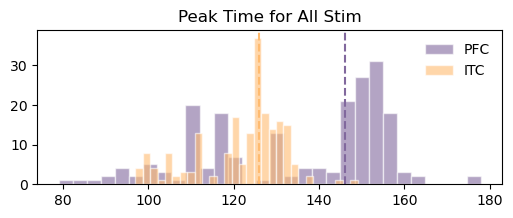

In [9]:
base_time_idx = (timestamps>-50) & (timestamps<50)

# resp_win is ok, because I only care about peak time
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(it2pfc, timestamps, base_time_idx, resp_win=[-50,600])
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(pfc2it, timestamps, base_time_idx, resp_win=[-50,600])

figure_size=(6,2)

plt.figure(figsize=figure_size)

plot_num = 1
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(wilcoxon(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(wilcoxon(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(wilcoxon(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(f'{plot_title} for {myCond}')

PFC-ITC = -6.0 -+ 29.367381565267273
Wilcoxon p = 1.3948416285073228e-06


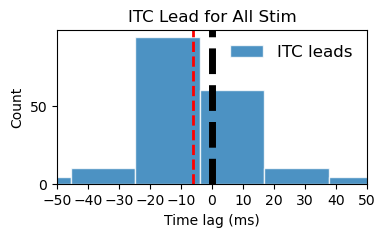

In [10]:
plot_xlim = [-50,50]
plot_ylim = [0,50]
figure_size = (4,2)

diffs = onsetsss_pfc - onsetsss_itc

plt.figure(figsize=figure_size)
plt.hist(diffs, bins=10, alpha=.8, label='ITC leads', edgecolor=[1,1,1])

plt.axvline(0, ls='--', color='k', lw=5)
plt.axvline(np.nanmedian(diffs), ls='--', color='r', lw=2)

plt.xlabel('Time lag (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks(np.arange(plot_xlim[0],plot_xlim[1]+1,10))

plt.ylabel('Count')
plt.yticks([plot_ylim[0],plot_ylim[1]])

plt.title('ITC Lead for '+myCond)
plt.legend(frameon=False, fontsize=12)

print(f'PFC-ITC = {np.nanmedian(diffs)} -+ {np.nanstd(diffs)}')
print(f"Wilcoxon p = {wilcoxon(diffs, nan_policy='omit', method='exact', zero_method='zsplit')[1]}")

# plt.savefig(f'{FigDir}rsagranger_{myCond}_stat_both.svg')

([<matplotlib.axis.YTick at 0x1d00bc2a2d0>,
 [Text(0, 0.0, '0.0'), Text(0, 0.2, '0.2')])

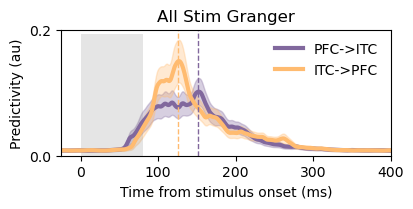

In [ ]:
smooth_win = 2
plot_xlim = [-25,400]
plot_ylim = [.0,.2]
figure_size = np.array((4,2)) * 1

m_plot([pfc2it,it2pfc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC->ITC','ITC->PFC'], plot_title=f'{myCond} Granger', timepoints=timestamps, figure_size=figure_size)

# plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=figure_size[1]*.5)
# plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.axvline(timestamps[np.nanmean(pfc2it, axis=0).argmax()], ls='--', color=color_pfc_n[:3], alpha=1, lw=figure_size[1]*.5)
plt.axvline(timestamps[np.nanmean(it2pfc, axis=0).argmax()], ls='--', color=color_itc_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel('Predictivity (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}rsagranger_{myCond}_both.svg')

Onset ITC = 62.0 -+ 23.374344375832237
Onset PFC = 57.0 -+ 21.38590131371601
Onset Permutation p = 0.03901921961560769
Onset Mann-Whitney p = 4.332195143088935e-14
-----
Peak ITC = 126.0 -+ 10.323844971714754
Peak PFC = 146.0 -+ 21.065359598164946
Peak Permutation p = 1.999960000799984e-05
Peak Mann-Whitney p = 1.7271678680068432e-11
-----
Solution ITC = 62.0 -+ 25.7297085098141
Solution PFC = 88.5 -+ 32.133882429610026
Solution Permutation p = 1.999960000799984e-05
Solution Mann-Whitney p = 1.5804495419461516e-10


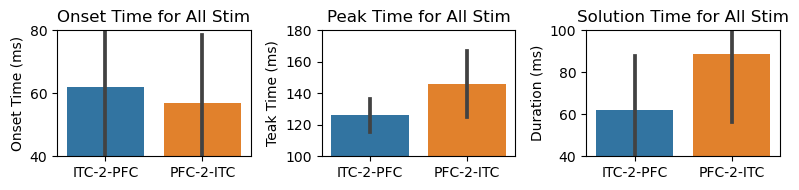

In [25]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
# error_method = ('ci', 95)
error_method = 'sd'
# error_method = 'se'
bar_xticks = ["ITC-2-PFC", "PFC-2-ITC"]

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator='median', errorbar=error_method)
ax[0].set_ylim([40,80])
ax[0].set_yticks([40,60,80])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=bar_xticks)

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator='median', errorbar=error_method)
ax[1].set_ylim([100,180])
ax[1].set_yticks([100,120,140,160,180])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=bar_xticks)

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator='median', errorbar=error_method)
ax[2].set_ylim([40,100])
ax[2].set_yticks([40,60,80,100])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=bar_xticks)

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onsetsss_itc)} -+ {np.nanstd(onsetsss_itc)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc)} -+ {np.nanstd(onsetsss_pfc)}')
print(f"Onset Permutation p = {comp_permute_p(onsetsss_itc, onsetsss_pfc)}")
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc)} -+ {np.nanstd(peaksss_itc)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc)} -+ {np.nanstd(peaksss_pfc)}')
print(f"Peak Permutation p = {comp_permute_p(peaksss_itc, peaksss_pfc)}")
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc)} -+ {np.nanstd(solsss_itc)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc)} -+ {np.nanstd(solsss_pfc)}')
print(f"Solution Permutation p = {comp_permute_p(solsss_itc, solsss_pfc)}")
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}rsagranger_{myCond}_stat_both_(40-20).svg')

In [26]:
# this cell is extra
if 0:
    rand_itc2pfc = comp_bs_dist(it2pfc)
    rand_pfc2itc = comp_bs_dist(pfc2it)

    # resp_win is ok, beacuse I only care about the peak time
    _, peak_boots_itc, onset_boots_itc, sol_boots_itc, _ = FindResp(rand_itc2pfc, timestamps, base_time_idx, resp_win=[-50,600])
    _, peak_boots_pfc, onset_boots_pfc, sol_boots_pfc, _ = FindResp(rand_pfc2itc, timestamps, base_time_idx, resp_win=[-50,600])

    p_perm_onset = comp_permute_p(onset_boots_itc, onset_boots_pfc)
    p_perm_peak  = comp_permute_p(peak_boots_itc, peak_boots_pfc)
    p_perm_sol   = comp_permute_p(sol_boots_itc, sol_boots_pfc)

## RSA ##

In [6]:
itc, pfc = [], []
for iCycle in tqdm(range(cycle_num)):
   itc.append(compute_rsa(resp_it[:,idx_rand[iCycle],:], conds_ls=[stim_num,stim_num]))
   pfc.append(compute_rsa(resp_pfc[:,idx_rand[iCycle],:], conds_ls=[stim_num,stim_num]))

itc = np.array(itc)
pfc = np.array(pfc)

  0%|          | 0/500 [00:00<?, ?it/s]

# FaceBody

MannwhitneyuResult(statistic=41501.0, pvalue=1.1140428070471313e-11)


Text(0.5, 1.0, 'RSA Solution Time for FaceBody')

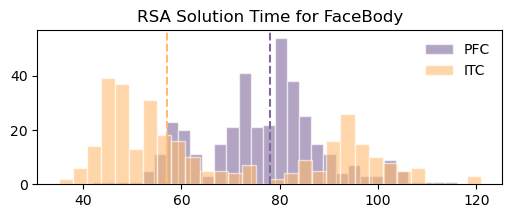

In [7]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(itc, time_stamps, base_time_idx)
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(pfc, time_stamps, base_time_idx)

figure_size=(6,2)

plt.figure(figsize=figure_size)

plot_num = 3
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(solsss_itc, solsss_pfc, nan_policy='omit'))
    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(f'RSA {plot_title} for {myCond}')

([<matplotlib.axis.YTick at 0x1f7804b3d90>,
 [Text(0, 0.0, '0.0'), Text(0, 0.0, '0.0'), Text(0, 0.7, '0.7')])

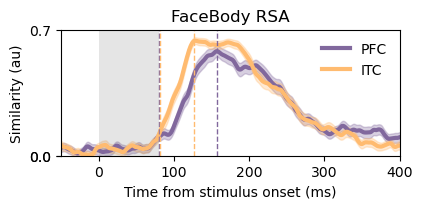

In [12]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.7]
figure_size = np.array((4,2)) * 1

m_plot([pfc,itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} RSA', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=figure_size[1]*.5)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.axvline(time_stamps[np.nanmean(pfc, axis=0).argmax()], ls='--', color=color_pfc_n[:3], alpha=1, lw=figure_size[1]*.5)
plt.axvline(time_stamps[np.nanmean(itc, axis=0).argmax()], ls='--', color=color_itc_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Similarity (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

# plt.savefig(f'{FigDir}rsa_{myCond}_both.svg')

Onset ITC = 81.0 -+ 5.642293246653969
Onset PFC = 80.0 -+ 11.646069437081911
Onset Permutation p = 0.004419911601767965
Onset p (comp_means) = 0.8289516676821336
-----
Peak ITC = 135.0 -+ 21.73286744171658
Peak PFC = 157.0 -+ 7.51425028418227
Peak Permutation p = 1.999960000799984e-05
Peak p (comp_means) = 0.46521317998351375
-----
Solution ITC = 57.0 -+ 22.127148017272916
Solution PFC = 78.0 -+ 12.435834672429511
Solution Permutation p = 1.999960000799984e-05
Solution p (comp_means) = 0.5905607327978708


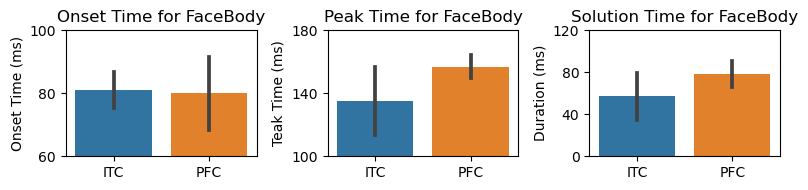

In [13]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
# error_method = ('ci', 95)
error_method = 'sd'
# error_method = 'se'

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator='median', errorbar=error_method)
ax[0].set_ylim([60,100])
ax[0].set_yticks([60,80,100])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator='median', errorbar=error_method)
ax[1].set_ylim([100,180])
ax[1].set_yticks([100,140,180])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator='median', errorbar=error_method)
ax[2].set_ylim([0,120])
ax[2].set_yticks([0,40,80,120])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onsetsss_itc)} -+ {np.nanstd(onsetsss_itc)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc)} -+ {np.nanstd(onsetsss_pfc)}')
print(f"Onset Permutation p = {comp_permute_p(onsetsss_itc, onsetsss_pfc)}")
print(f"Onset p (comp_means) = {compare_means_bs(onsetsss_itc, onsetsss_pfc)}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc)} -+ {np.nanstd(peaksss_itc)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc)} -+ {np.nanstd(peaksss_pfc)}')
print(f"Peak Permutation p = {comp_permute_p(peaksss_itc, peaksss_pfc)}")
print(f"Peak p (comp_means) = {compare_means_bs(peaksss_itc, peaksss_pfc)}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc)} -+ {np.nanstd(solsss_itc)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc)} -+ {np.nanstd(solsss_pfc)}')
print(f"Solution Permutation p = {comp_permute_p(solsss_itc, solsss_pfc)}")
print(f"Solution p (comp_means) = {compare_means_bs(solsss_itc, solsss_pfc)}")

# plt.savefig(f'{FigDir}rsa_{myCond}_stat_both.svg')

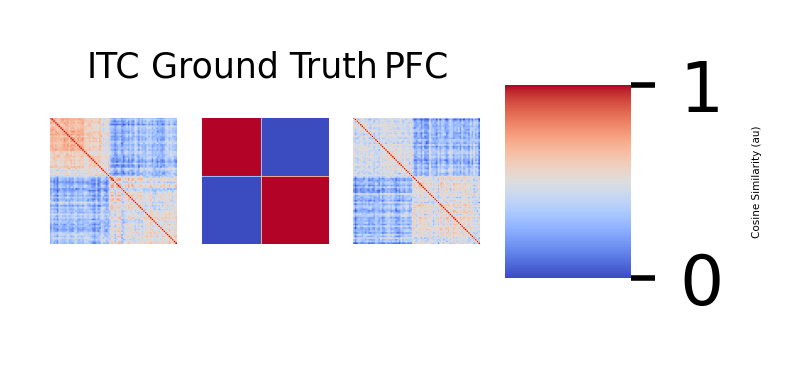

In [28]:
fig_sz = .5

if 1:
    idx_peak_itc = np.nanmean(itc, axis=0).argmax()
    idx_peak_pfc = np.nanmean(pfc, axis=0).argmax()

    repmats = [mk_repmat_data(resp_it[:,ind_all,idx_peak_itc]),
            mk_repmat_kernel([len(indc1),len(indc2)]), 
            mk_repmat_data(resp_pfc[:,ind_all,idx_peak_pfc])]

    plot_repmat(repmats,plot_sz=fig_sz, titles=['ITC','Ground Truth','PFC'], show_clb=True)
#     plt.savefig(f'{FigDir}repmat_{myCond}_both.svg')

# Animacy

MannwhitneyuResult(statistic=26173.0, pvalue=5.76360373028995e-41)


Text(0.5, 1.0, 'RSA Solution Time for Animacy')

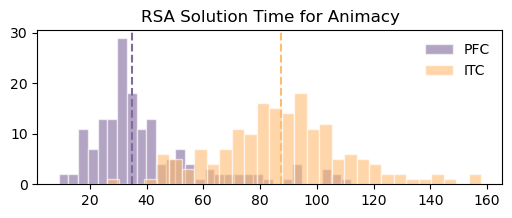

In [13]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(itc, time_stamps, base_time_idx)
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(pfc, time_stamps, base_time_idx)

figure_size=(6,2)

plt.figure(figsize=figure_size)

plot_num = 3
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(solsss_itc, solsss_pfc, nan_policy='omit'))
    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(f'RSA {plot_title} for {myCond}')

([<matplotlib.axis.YTick at 0x2b7e96f0950>,
 [Text(0, 0.0, '0.00'), Text(0, 0.0, '0.00'), Text(0, 0.15, '0.15')])

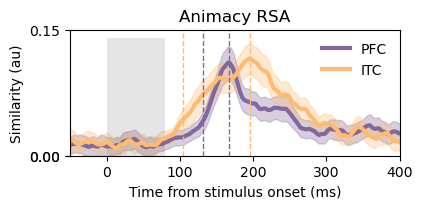

In [15]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.15]
figure_size = np.array((4,2)) * 1

m_plot([pfc,itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} RSA', timepoints=time_stamps, figure_size=figure_size)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=figure_size[1]*.5)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.axvline(time_stamps[np.nanmean(pfc, axis=0).argmax()], ls='--', color=color_pfc_n[:3], alpha=1, lw=figure_size[1]*.5)
plt.axvline(time_stamps[np.nanmean(itc, axis=0).argmax()], ls='--', color=color_itc_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Similarity (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

# plt.savefig(f'{FigDir}rsa_{myCond}_both.svg')

Onset ITC = 104.0 -+ 15.619983240057792
Onset PFC = 131.0 -+ 21.172352330668357
Onset Permutation p = 1.999960000799984e-05
Onset Mann-Whitney p = 2.2139838466802377e-23
-----
Peak ITC = 195.0 -+ 15.58673437684568
Peak PFC = 167.0 -+ 6.555312441990939
Peak Permutation p = 1.999960000799984e-05
Peak Mann-Whitney p = 8.844211987324822e-38
-----
Solution ITC = 87.5 -+ 23.018207691812776
Solution PFC = 35.0 -+ 21.346591954277915
Solution Permutation p = 1.999960000799984e-05
Solution Mann-Whitney p = 5.76360373028995e-41


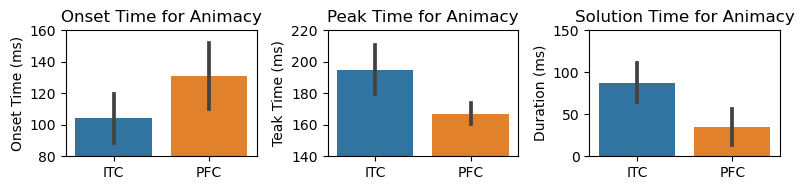

In [16]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
# error_method = ('ci', 95)
error_method = 'sd'
# error_method = 'se'

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator='median', errorbar=error_method)
ax[0].set_ylim([80,160])
ax[0].set_yticks([80,100,120,140,160])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=["ITC", "PFC"])

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator='median', errorbar=error_method)
ax[1].set_ylim([140,220])
ax[1].set_yticks([140,160,180,200,220])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=["ITC", "PFC"])

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator='median', errorbar=error_method)
ax[2].set_ylim([0,150])
ax[2].set_yticks([0,50,100,150])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=["ITC", "PFC"])

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onsetsss_itc)} -+ {np.nanstd(onsetsss_itc)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc)} -+ {np.nanstd(onsetsss_pfc)}')
print(f"Onset Permutation p = {comp_permute_p(onsetsss_itc, onsetsss_pfc)}")
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc)} -+ {np.nanstd(peaksss_itc)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc)} -+ {np.nanstd(peaksss_pfc)}')
print(f"Peak Permutation p = {comp_permute_p(peaksss_itc, peaksss_pfc)}")
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc)} -+ {np.nanstd(solsss_itc)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc)} -+ {np.nanstd(solsss_pfc)}')
print(f"Solution Permutation p = {comp_permute_p(solsss_itc, solsss_pfc)}")
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}rsa_{myCond}_stat_both.svg')

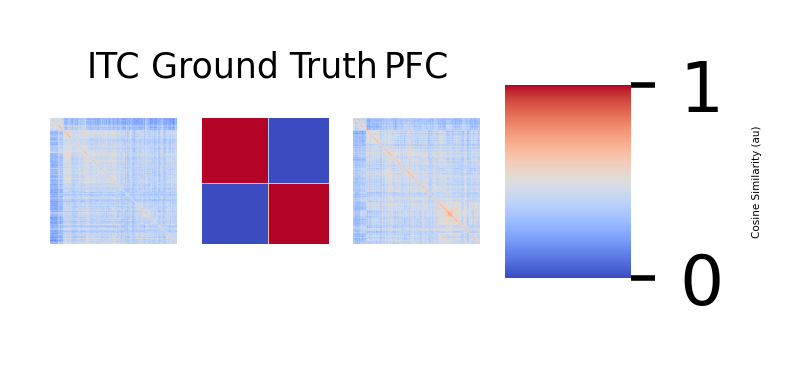

In [20]:
fig_sz = .5

if 1:
    idx_peak_itc = np.nanmean(itc, axis=0).argmax()
    idx_peak_pfc = np.nanmean(pfc, axis=0).argmax()

    repmats = [mk_repmat_data(resp_it[:,ind_all,idx_peak_itc]),
            mk_repmat_kernel([len(indc1),len(indc2)]), 
            mk_repmat_data(resp_pfc[:,ind_all,idx_peak_pfc])]

    plot_repmat(repmats,plot_sz=fig_sz, titles=['ITC','Ground Truth','PFC'], show_clb=True)
#     plt.savefig(f'{FigDir}repmat_{myCond}_both.svg')